In [1]:
import pandas as pd
import numpy as np

In [2]:
# Kalman Filter Algoostthm
class KalmanFilter(object):
    def __init__(self, A = None, B = None, C = None, Q = None, R = None, p0 = None, x0 = None):
        if(A is None or C is None):
            raise ValueError("Provide state and measurement matrix A and C.")

        # No. of State Variables
        self.n = A.shape[1]
        # No. of Measurements
        self.m = C.shape[0]

        self.A = A
        self.C = C
        self.B = np.zeros((self.n, self.m)) if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.m) if R is None else R
        self.P = np.eye(self.n) if p0 is None else p0
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

        # Verify dimensionality
        if(self.n != C.shape[1]):
            raise Exception('Dimensionality mismatch in matrix C')
        if(not(self.B is None) and ((self.n, self.m) != B.shape)):
            raise Exception('Dimensionality mismatch in matrix B')
        if(not(self.Q is None) and (self.n != self.Q.shape[0])):
            raise Exception('Dimensionality mismatch in matrix Q')
        if(not(self.R is None) and (self.m != self.R.shape[0])):
            raise Exception('Dimensionality mismatch in matrix R')
        if(not(self.P is None) and (self.n != self.P.shape[0])):
            raise Exception('Dimensionality mismatch in matrix P')
        if(not(self.x is None) and (self.n != self.x.shape[0])):
            raise Exception('Dimensionality mismatch in matrix x0')

    def predict(self, u = 0):
        #self.x = np.dot(self.A, self.x) + np.dot(self.B, u)
        #self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        self.x = (self.A @ self.x) + (self.B @ u)
        self.P = (self.A @ self.P @ self.A.T) + self.Q
        return self.x, self.P

    def update(self, z_true):
        S = self.R + (self.C @ self.P @ self.C.T)
        K = (self.P @ self.C.T) @ np.linalg.inv(S)

        z_est = self.C @ self.x
        Innov = z_true - z_est
        self.x = self.x + K @ Innov
        Residual = z_true - self.C @ self.x
        self.P = self.P - ((K @ self.C) @ self.P)

        return K, z_est, Innov, Residual, self.x, self.P
        #y = z - np.dot(self.C, self.x)
        #S = self.R + np.dot(self.C, np.dot(self.P, self.C.T))
        #K = np.dot(np.dot(self.P, self.C.T), np.linalg.inv(S))
        #self.x = self.x + np.dot(K, y)
        #I = np.eye(self.n)
        #self.P = np.dot(np.dot(I - np.dot(K, self.C), self.P), 
        #	(I - np.dot(K, self.C)).T) + np.dot(np.dot(K, self.R), K.T)

In [3]:
# Load the Excel sheet into a pandas DataFrame
df_measurements = pd.read_excel('Link 2 Measurements.xlsx')

# Convert the DataFrame to a 2D array
y_array = df_measurements.values


In [4]:
# Execute State Estimation Sequence 4-Tank Problem

# Size of state time sequence T
T = y_array.shape[0] - 1

# Initialize 4 tank system parameters
# cross-section of Tank (cm^2)
A_i = [28, 32, 28, 32]
# cross-section of the outlet hole (cm^2)
a_i = [0.071, 0.057, 0.071, 0.057]

gamma_i = [0.7, 0.6] #valve position
k_i = [3.33, 3.35] #cm^3/Vs
v_i = [3, 3] #V

# water level @t=0
h0_i = [12.4, 12.7, 1.8, 1.4]

kc = 0.5 #V/cm
g = 981 #cm/s^2

# Time Constants
T_i = np.divide(A_i, a_i)*((2*np.divide(h0_i, g))**0.5)

# Generating Linear State Space Model
A = np.zeros((4, 4))
B = np.zeros((4, 2))
C = np.zeros((2, 4))
#C = np.zeros((4, 4))
m = C.shape[0]
n = C.shape[1]

A[0][0] = -1/T_i[0]; 
A[1][1] = -1/T_i[1]; 
A[2][2] = -1/T_i[2]; 
A[3][3] = -1/T_i[3] 
A[0][2] = A_i[2]/(A_i[0]*T_i[2])
A[1][3] = A_i[3]/(A_i[1]*T_i[3])

B[0][0] = gamma_i[0]*k_i[0]/A_i[0]
B[1][1] = gamma_i[1]*k_i[1]/A_i[1]
B[2][1] = (1 - gamma_i[1])*k_i[1]/A_i[2]
B[3][0] = (1 - gamma_i[0])*k_i[0]/A_i[3]

C[0][0] = C[1][1] = kc
#C[2][2] = C[3][3] = kc



# Create storing variables for 
#  X - state matrix,
X_pri_array = []
X_post_array = []
#  K - kalman gain,
K_array = []
#  P - error covariance,
P_pri_array = []
P_post_array = []
#  Z i- estimated measurement
#  Innov - Innovation (pre-fit residual)
#  Resid - Residual (post-fit residual)
Z_est_array = []
Innov_array = []
Resid_array = []

X_0 = np.ones(n)
P_0 = (10E5*np.eye(n))
Q = (8*np.eye(n))
R = (2*np.eye(m))
Q[2,0] = Q[3, 1] = Q[0,2] = Q[1,3] = Q[2,2] = Q[3,3] = 1
X_post_array.append(X_0)
P_post_array.append(P_0)

print('A\n', A)
print('B\n', B)
print('C\n', C)
print('Q\n', Q)
print('R\n', R)

# Create Kalman Filter
kf = KalmanFilter(A, B, C, Q, R, P_0, X_0)

u = [v_i[0], v_i[1]]

X_post_old = np.zeros(n)
for t in range(0,T):
    # PREDICT
    (X_pri, P_pri) = kf.predict(u)
    X_pri_array.append(X_pri)
    P_pri_array.append(P_pri)
    # UPDATE
    (K, Z_est, Innov, Resid, X_post, P_post) = kf.update(y_array[t, :2])
    K_array.append(K)
    Z_est_array.append(Z_est)
    Innov_array.append(Innov)
    Resid_array.append(Resid)
    X_post_array.append(X_post)
    P_post_array.append(P_post)

    # Calculate the L2 norm
    l2_norm = np.linalg.norm(X_pri - X_post)
    X_post_old = X_post

    # Check if the L2 norm is less than or equal to the threshold
    threshold = 5e-3
    if l2_norm <= threshold:
        print("L2 norm is less than or equal to the threshold.")
        print(t)
        break

print("Final Measurements:", y_array[t, :])
print("Final Estimates:", X_post)

A
 [[-0.0159481   0.          0.04185849  0.        ]
 [ 0.         -0.01106987  0.          0.03334113]
 [ 0.          0.         -0.04185849  0.        ]
 [ 0.          0.          0.         -0.03334113]]
B
 [[0.08325    0.        ]
 [0.         0.0628125 ]
 [0.         0.04785714]
 [0.03121875 0.        ]]
C
 [[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]]
Q
 [[8. 0. 1. 0.]
 [0. 8. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]]
R
 [[2. 0.]
 [0. 2.]]
Final Measurements: [12.26296752 12.7831584   1.63394113  1.4090447 ]
Final Estimates: [12.32457053 12.83443019  1.59977599  1.62944726]


In [5]:
T = t+1
K_Store = np.vstack(K_array).reshape(T,8)

Z_est_Store = np.vstack(Z_est_array)
Innov_Store = np.vstack(Innov_array)
Resid_Store = np.vstack(Resid_array)


X_Pri_Store = np.vstack(X_pri_array)
X_Post_Store = np.vstack(X_post_array)

P_Pri_Store = np.vstack(P_pri_array).reshape(T,16)
P_Post_Store = np.vstack(P_post_array).reshape(T+1,16)


In [25]:
P_Post_Store.shape

(10001, 16)

In [26]:
K_Store#,Z_est_Store,Innov_Store,Resid_Store,X_Pri_Store,X_Post_Store,P_Pri_Store,P_Post_Store

array([[ 1.9920889 ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.7767637 ],
       [ 1.02595948,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.10619786],
       [ 1.00019434,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.12485661],
       ...,
       [ 1.00012478,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.12488352],
       [ 1.00012478,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.12488352],
       [ 1.00012478,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.12488352]])

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def Plot_MultipleSeries(matrix, labels):
    num_columns = matrix.shape[1]
    num_rows = (num_columns + 3) // 4  # Calculate the number of rows based on the number of columns

    # Create subplots with a maximum of 4 columns per row
    fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3*num_rows))

    # Flatten the axes array
    axes = axes.flatten()

    time = np.arange(0, matrix.shape[0]) * 0.1  # Generate the time values

    # Iterate over the columns and plot each one
    for i in range(num_columns):
        ax = axes[i]
        ax.plot(time, matrix[:, i], label=f'{labels[i]}')
        #ax.set_title()
        ax.set_xlabel('Time (sec)')
        ax.legend()
        #ax.set_ylabel(f'{labels[i]}')

    # Hide empty subplots
    for j in range(num_columns, num_rows*4):
        fig.delaxes(axes[j])

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()


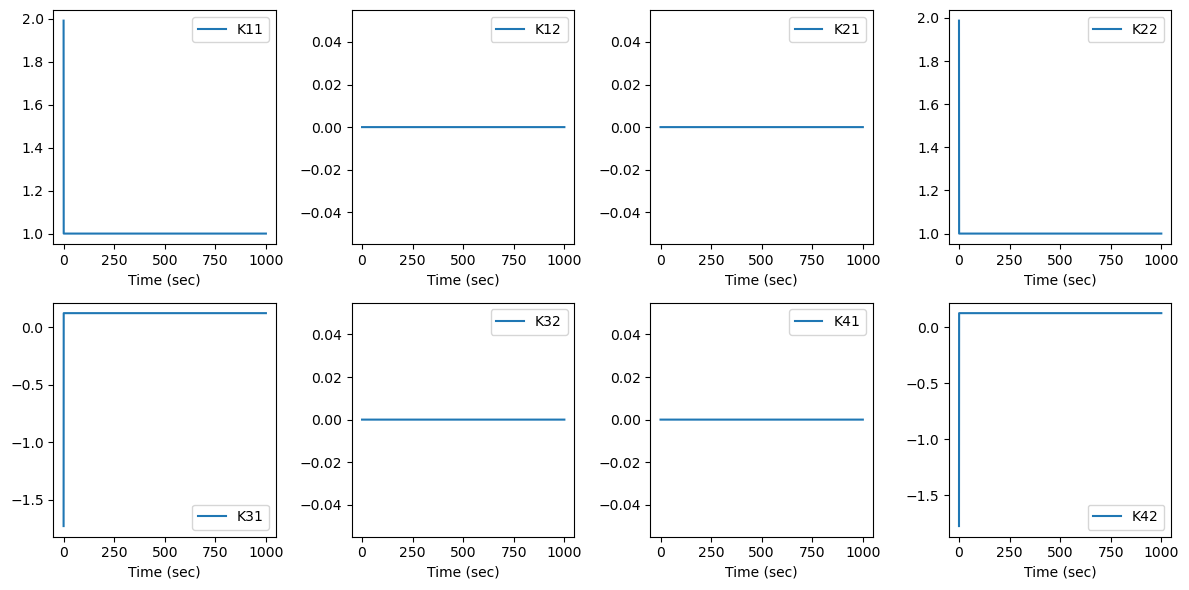

In [7]:
Plot_MultipleSeries(K_Store, ['K11', 'K12', 'K21', 'K22', 'K31', 'K32', 'K41', 'K42'])

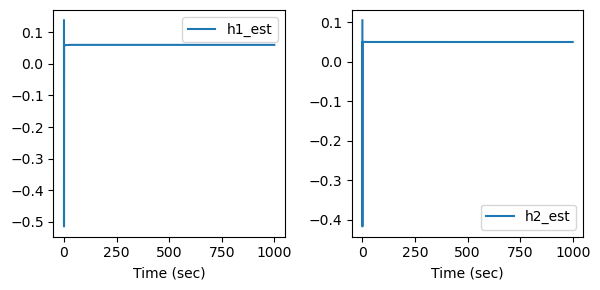

In [8]:
Plot_MultipleSeries(Z_est_Store, ["h1_est", "h2_est"])

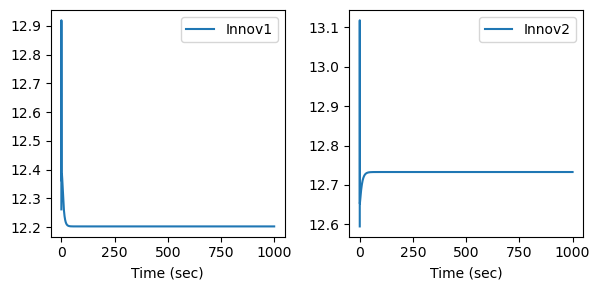

In [9]:
Plot_MultipleSeries(Innov_Store, ["Innov1", "Innov2"])

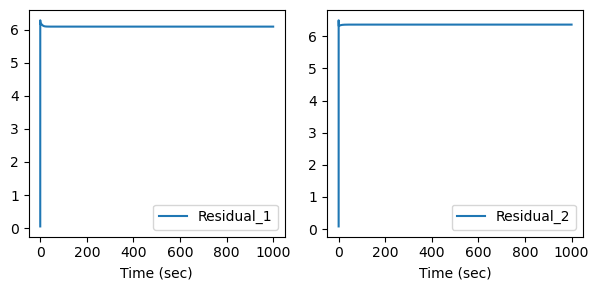

In [10]:
Plot_MultipleSeries(Resid_Store, ["Residual_1", "Residual_2"])

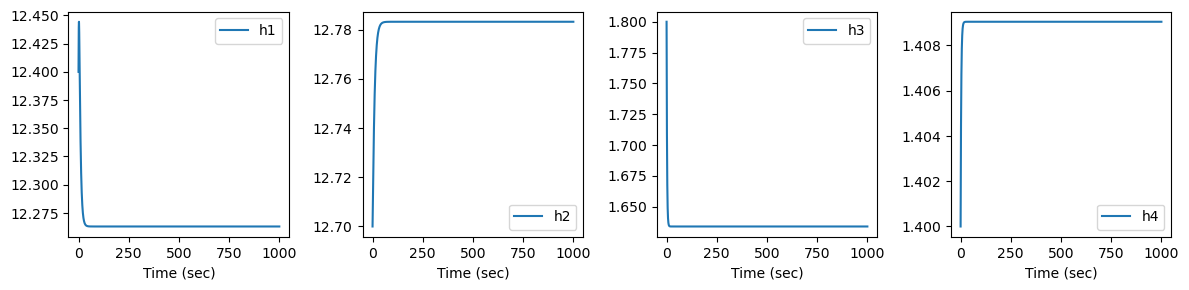

In [11]:
Plot_MultipleSeries(y_array[:T+1,:], df_measurements.columns.tolist())

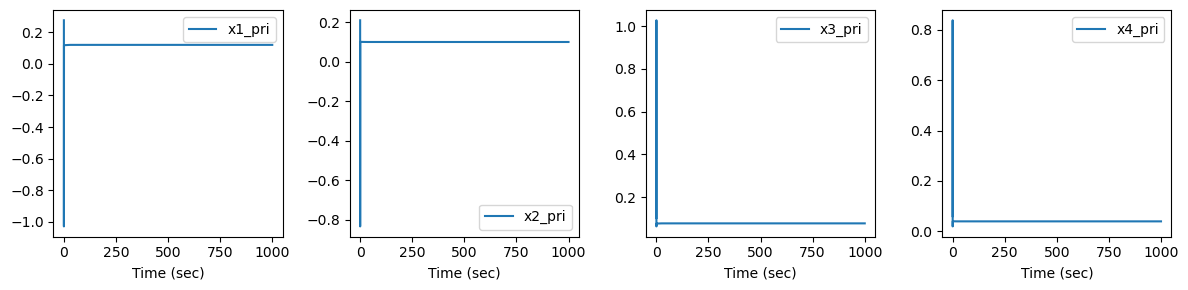

In [12]:
Plot_MultipleSeries(X_Pri_Store, ["x1_pri", "x2_pri", "x3_pri", "x4_pri"])

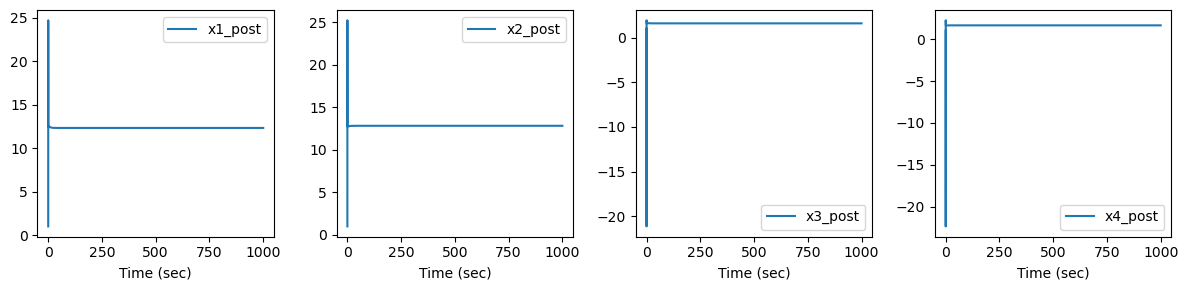

In [13]:
Plot_MultipleSeries(X_Post_Store, ["x1_post", "x2_post", "x3_post", "x4_post"])

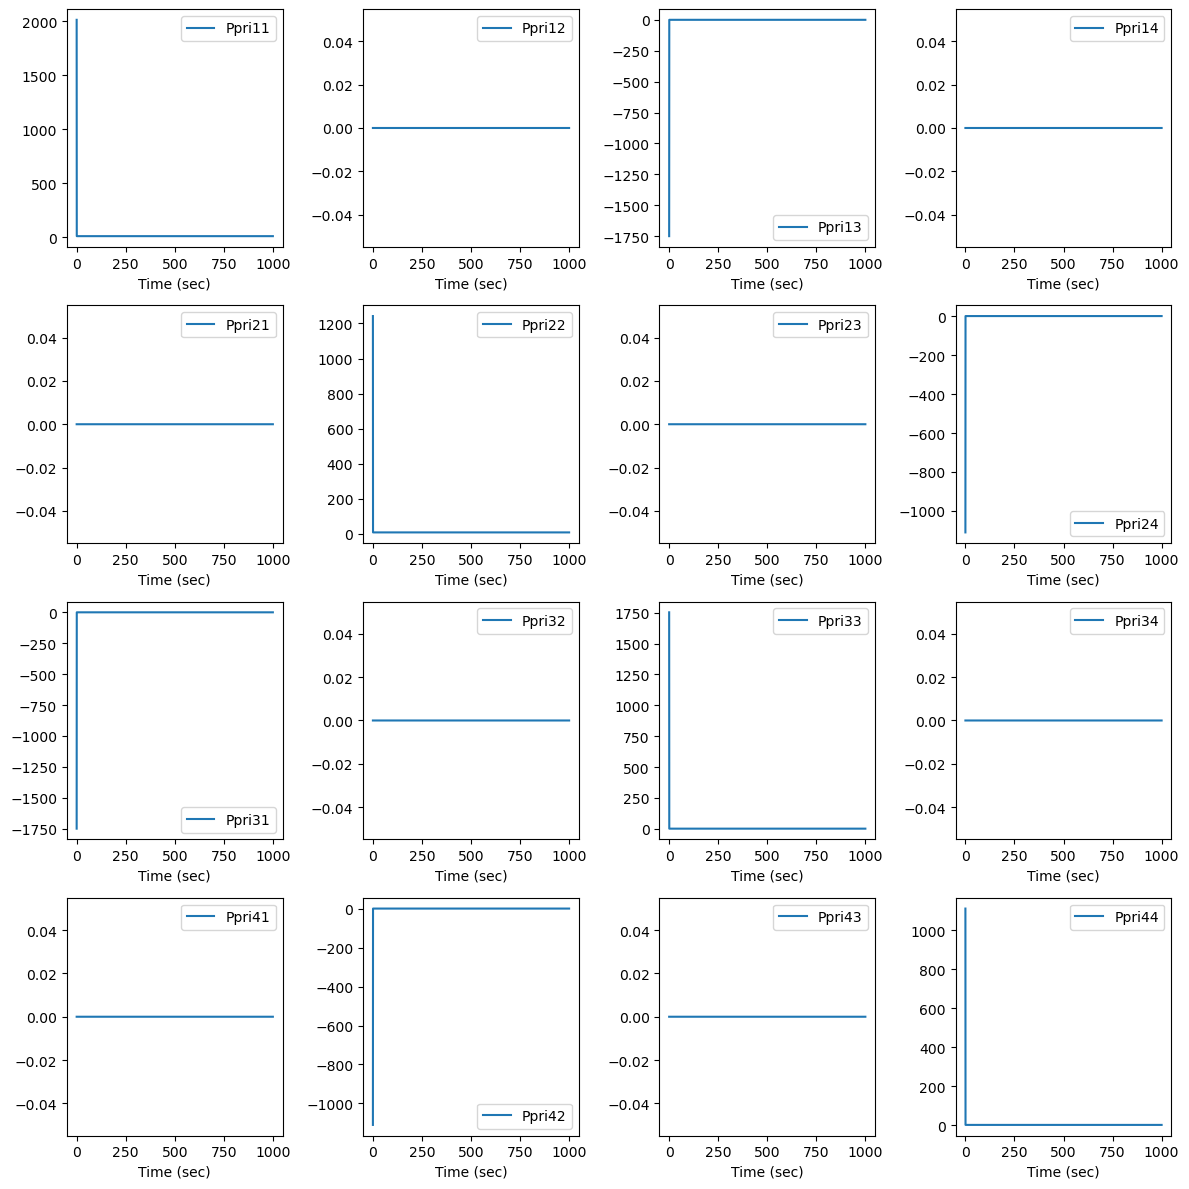

In [14]:
Plot_MultipleSeries(P_Pri_Store, ["Ppri11", "Ppri12", "Ppri13", "Ppri14", "Ppri21", "Ppri22", "Ppri23", "Ppri24", "Ppri31", "Ppri32", "Ppri33", "Ppri34", "Ppri41", "Ppri42", "Ppri43", "Ppri44"])

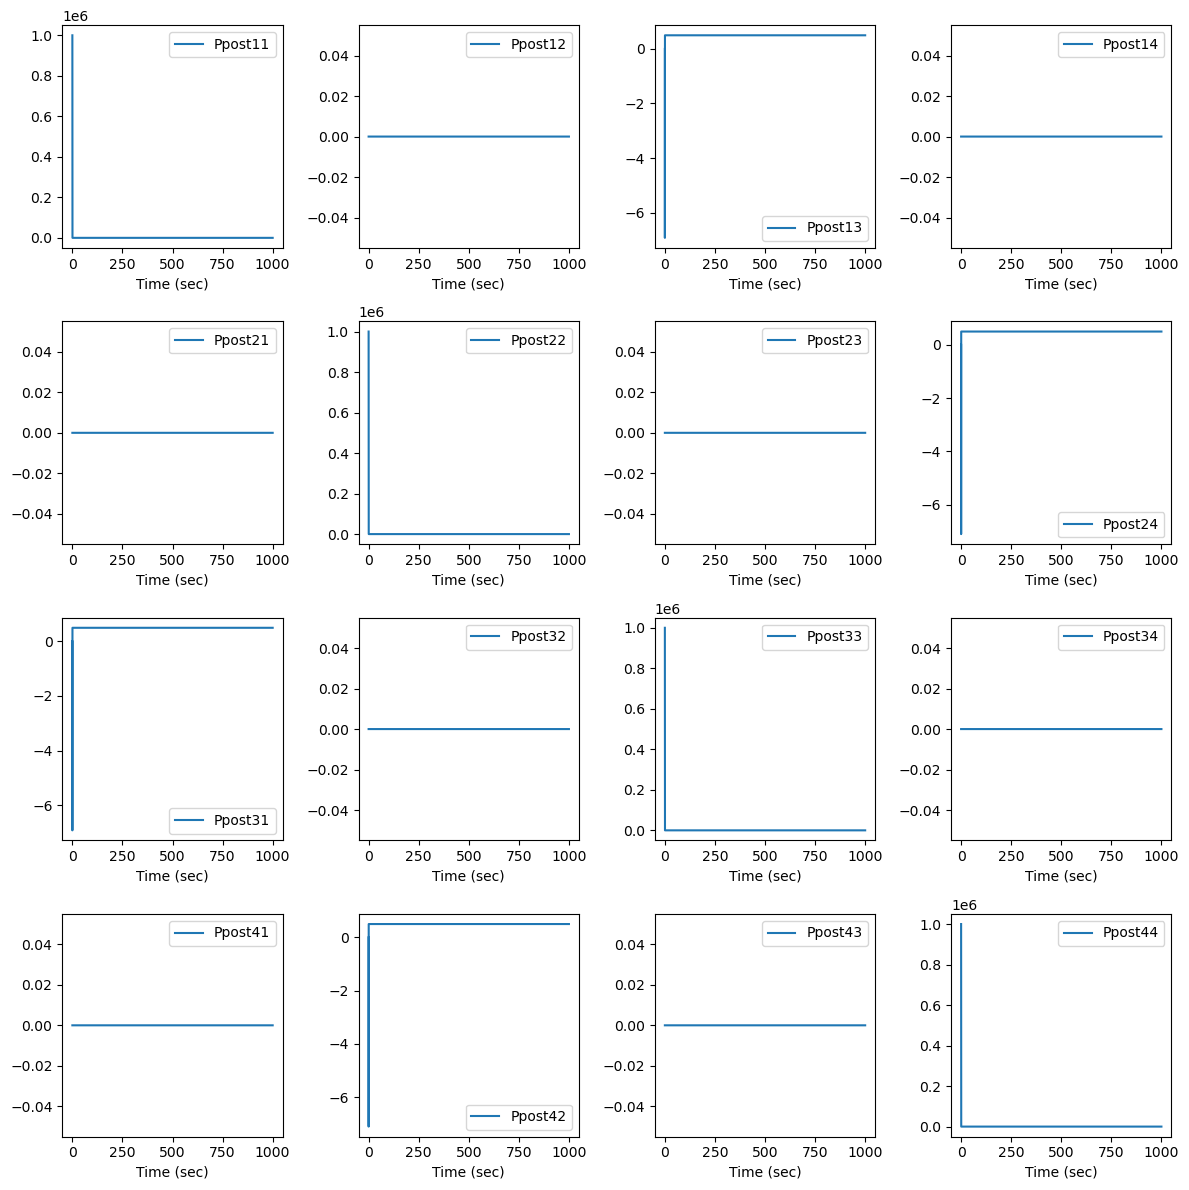

In [15]:
Plot_MultipleSeries(P_Post_Store, ["Ppost11", "Ppost12", "Ppost13", "Ppost14", "Ppost21", "Ppost22", "Ppost23", "Ppost24", "Ppost31", "Ppost32", "Ppost33", "Ppost34", "Ppost41", "Ppost42", "Ppost43", "Ppost44"])